# Flipkart Mobile dataset analysis using Python

## Data cleaning and preproccessing

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("Flipkart_Mobiles.csv", encoding='utf-8', low_memory=False)

In [3]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(10))
display(df.info())
display(df.describe(include='all').T)

Shape: (3114, 8)
Columns: ['Brand', 'Model', 'Color', 'Memory', 'Storage', 'Rating', 'Selling Price', 'Original Price']


,Brand,Model,Color,Memory,Storage,Rating,Selling Price,Original Price
0,OPPO,A53,Moonlight Black,4 GB,64 GB,4.5,11990,15990
1,OPPO,A53,Mint Cream,4 GB,64 GB,4.5,11990,15990
2,OPPO,A53,Moonlight Black,6 GB,128 GB,4.3,13990,17990
3,OPPO,A53,Mint Cream,6 GB,128 GB,4.3,13990,17990
4,OPPO,A53,Electric Black,4 GB,64 GB,4.5,11990,15990
5,OPPO,A53,Electric Black,6 GB,128 GB,4.3,13990,17990
6,OPPO,A12,Deep Blue,4 GB,64 GB,4.4,10490,11990
7,OPPO,A12,Black,3 GB,32 GB,4.4,9490,10990
8,OPPO,A12,Blue,3 GB,32 GB,4.4,9490,10990
9,OPPO,A12,Flowing Silver,3 GB,32 GB,4.4,9490,10990


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           3114 non-null   object 
 1   Model           3114 non-null   object 
 2   Color           3114 non-null   object 
 3   Memory          3071 non-null   object 
 4   Storage         3075 non-null   object 
 5   Rating          2970 non-null   float64
 6   Selling Price   3114 non-null   int64  
 7   Original Price  3114 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 194.8+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,3114,17,SAMSUNG,719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,3114,914,iPhone 11,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Color,3114,639,Black,489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Memory,3071,26,4 GB,750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Storage,3075,26,64 GB,774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,2970.0,NaN,NaN,NaN,4.243098,0.271991,2.3,4.1,4.3,4.4,5.0
Selling Price,3114.0,NaN,NaN,NaN,26436.625562,30066.892622,1000.0,9990.0,15000.0,28999.0,179900.0
Original Price,3114.0,NaN,NaN,NaN,28333.473025,31525.599889,1000.0,10030.25,16889.5,31500.0,189999.0


In [4]:
missing = df.isnull().sum()
missing_pct = (df.isnull().mean()*100).round(2)
print(pd.concat([missing, missing_pct], axis=1).rename(columns={0:'missing_count',1:'missing_pct'}))

                missing_count  missing_pct
Brand                       0         0.00
Model                       0         0.00
Color                       0         0.00
Memory                     43         1.38
Storage                    39         1.25
Rating                    144         4.62
Selling Price               0         0.00
Original Price              0         0.00


In [5]:

def clean_price_col(col):
    if df[col].dtype == 'O':
        return df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).replace('', np.nan).astype(float)
    else:
        return pd.to_numeric(df[col], errors='coerce')

df['Selling Price'] = clean_price_col('Selling Price')
df['Original Price'] = clean_price_col('Original Price')


df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

df.loc[(df['Rating'] < 0) | (df['Rating'] > 5), 'Rating'] = np.nan

df[['Selling Price','Original Price','Rating']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Selling Price   3114 non-null   int64  
 1   Original Price  3114 non-null   int64  
 2   Rating          2970 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 73.1 KB


In [6]:

df['Brand'] = df['Brand'].astype(str).str.strip()
df['Model'] = df['Model'].astype(str).str.strip()
df['Color'] = df['Color'].astype(str).str.strip()


df['Brand'] = df['Brand'].str.title()

brand_map = {
    'SAMSUNG': 'Samsung',
    'realme': 'Realme',
    'OPPO' : 'Oppo', 'vivo':'Vivo',
}
df['Brand'] = df['Brand'].replace(brand_map)


In [7]:
import re

def to_gb(val):
    if pd.isna(val): 
        return np.nan
    s = str(val).strip().lower()
    # numbers like '4 gb', '512 mb', '1.5 gb', '16 mb' etc.
    m = re.search(r'([\d\.]+)\s*(gb|mb)', s)
    if not m:
        # fallback: extract numeric and assume gb if >=4 else maybe mb? Keep as NaN
        try:
            return float(re.findall(r'[\d\.]+', s)[0])
        except:
            return np.nan
    num, unit = float(m.group(1)), m.group(2)
    if unit == 'mb':
        return num / 1024.0
    else:
        return num

df['RAM_GB'] = df['Memory'].apply(to_gb).round(3)
df['Storage_GB'] = df['Storage'].apply(to_gb).round(3)

df[['Memory', 'RAM_GB', 'Storage', 'Storage_GB']].head(10)


,Memory,RAM_GB,Storage,Storage_GB
0,4 GB,4.0,64 GB,64.0
1,4 GB,4.0,64 GB,64.0
2,6 GB,6.0,128 GB,128.0
3,6 GB,6.0,128 GB,128.0
4,4 GB,4.0,64 GB,64.0
5,6 GB,6.0,128 GB,128.0
6,4 GB,4.0,64 GB,64.0
7,3 GB,3.0,32 GB,32.0
8,3 GB,3.0,32 GB,32.0
9,3 GB,3.0,32 GB,32.0


In [8]:
# detect exact duplicate rows
dups = df.duplicated()
print("exact duplicates:", dups.sum())

# If duplicates exist, consider dropping
df = df.drop_duplicates().reset_index(drop=True)


exact duplicates: 108


In [10]:
# 1) Fill missing Rating by brand median
df['Rating'] = df['Rating'].fillna(
    df.groupby('Brand')['Rating'].transform('median')
)

# 2) If still NaN (brand has no ratings), fill with overall median
df['Rating'] = df['Rating'].fillna(df['Rating'].median())


# 3) For RAM/Storage: if missing and Model contains known patterns, extract (example)
# (you may need to craft regexes per your Model naming patterns)

# After imputation, check missing counts again
print(df[['RAM_GB','Storage_GB','Rating','Selling Price','Original Price']].isnull().sum())


RAM_GB            40
Storage_GB        39
Rating             0
Selling Price      0
Original Price     0
dtype: int64


In [11]:
# discount absolute and percent: (Original - Selling) and percent
df['discount_amt'] = (df['Original Price'] - df['Selling Price']).clip(lower=0)
df['discount_pct'] = (df['discount_amt'] / df['Original Price']).replace([np.inf, -np.inf], np.nan) * 100

# price per GB (approx using storage or RAM+storage as you choose)
df['price_per_storage_gb'] = df['Selling Price'] / df['Storage_GB']
# handle infinite/NaN
df.loc[~np.isfinite(df['price_per_storage_gb']), 'price_per_storage_gb'] = np.nan

# combine brand+model for unique name
df['full_name'] = (df['Brand'] + ' ' + df['Model']).str.strip()


In [12]:
# Detect price outliers via IQR
Q1 = df['Selling Price'].quantile(0.25)
Q3 = df['Selling Price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df[(df['Selling Price'] < lower) | (df['Selling Price'] > upper)]
print("price outliers count:", outliers.shape[0])

# Inspect outliers
display(outliers[['full_name','Selling Price','Original Price','RAM_GB','Storage_GB','Rating']].sort_values('Selling Price', ascending=False).head(20))

# Fix obvious errors (example): if Storage_GB < 1 (like 0.015 ~ 16 MB) -> treat as wrong, set to NaN
df.loc[df['Storage_GB'] < 0.5, 'Storage_GB'] = np.nan


price outliers count: 377


,full_name,Selling Price,Original Price,RAM_GB,Storage_GB,Rating
2950,Apple iPhone 13 Pro Max,179900,179900,4.0,1.0,4.7
2949,Apple iPhone 13 Pro Max,179900,179900,4.0,1.0,4.7
2943,Apple iPhone 13 Pro Max,179900,179900,4.0,1.0,4.7
1205,Apple iPhone 13 Pro Max,179900,179900,6.0,1.0,4.6
1291,Apple iPhone 13 Pro Max,179900,179900,6.0,1.0,4.6
2936,Apple iPhone 13 Pro Max,179900,179900,4.0,1.0,4.7
1227,Apple iPhone 13 Pro Max,179900,179900,6.0,NaN,4.6
1376,Apple iPhone 13 Pro Max,179900,179900,6.0,1.0,4.6
1332,Apple iPhone 13 Pro Max,179900,179900,6.0,1.0,4.6
1956,Samsung Fold 2 5G,169999,169999,12.0,256.0,4.3


In [13]:
# final dtypes & missing
display(df.info())
print(df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Brand                 3006 non-null   object 
 1   Model                 3006 non-null   object 
 2   Color                 3006 non-null   object 
 3   Memory                2966 non-null   object 
 4   Storage               2967 non-null   object 
 5   Rating                3006 non-null   float64
 6   Selling Price         3006 non-null   int64  
 7   Original Price        3006 non-null   int64  
 8   RAM_GB                2966 non-null   float64
 9   Storage_GB            2856 non-null   float64
 10  discount_amt          3006 non-null   int64  
 11  discount_pct          3006 non-null   float64
 12  price_per_storage_gb  2967 non-null   float64
 13  full_name             3006 non-null   object 
dtypes: float64(5), int64(3), object(6)
memory usage: 328.9+ KB


None

Brand                     0
Model                     0
Color                     0
Memory                   40
Storage                  39
Rating                    0
Selling Price             0
Original Price            0
RAM_GB                   40
Storage_GB              150
discount_amt              0
discount_pct              0
price_per_storage_gb     39
full_name                 0
dtype: int64


In [14]:
print(df.head())

  Brand Model            Color Memory Storage  Rating  Selling Price  \
0  Oppo   A53  Moonlight Black   4 GB   64 GB     4.5          11990   
1  Oppo   A53       Mint Cream   4 GB   64 GB     4.5          11990   
2  Oppo   A53  Moonlight Black   6 GB  128 GB     4.3          13990   
3  Oppo   A53       Mint Cream   6 GB  128 GB     4.3          13990   
4  Oppo   A53   Electric Black   4 GB   64 GB     4.5          11990   

   Original Price  RAM_GB  Storage_GB  discount_amt  discount_pct  \
0           15990     4.0        64.0          4000     25.015635   
1           15990     4.0        64.0          4000     25.015635   
2           17990     6.0       128.0          4000     22.234575   
3           17990     6.0       128.0          4000     22.234575   
4           15990     4.0        64.0          4000     25.015635   

   price_per_storage_gb full_name  
0            187.343750  Oppo A53  
1            187.343750  Oppo A53  
2            109.296875  Oppo A53  
3       

In [15]:
df.drop(columns=["Memory", "Storage"], inplace=True)


In [29]:
# ------------------------------
# 1. Clean column names (already clean, but safe)
# ------------------------------
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# ------------------------------
# 2. Function for grouped imputation
# ------------------------------
def grouped_impute(df, column, group_col):
    # Apply group mean
    group_mean = df.groupby(group_col)[column].transform("mean")
    df[column] = df[column].fillna(group_mean)

    # If still NaN → fill with overall median
    df[column] = df[column].fillna(df[column].median())

    return df

# ------------------------------
# 3. Impute RAM_GB by Model first → then Brand
# ------------------------------
df = grouped_impute(df, "ram_gb", "model")
df = grouped_impute(df, "ram_gb", "brand")

# ------------------------------
# 4. Impute STORAGE_GB by Model first → then Brand
# ------------------------------
df = grouped_impute(df, "storage_gb", "model")
df = grouped_impute(df, "storage_gb", "brand")

# ------------------------------
# 5. Recalculate price_per_storage_gb after fix
#    Formula = selling_price / storage_gb
# ------------------------------
# 5. Recalculate price_per_storage_gb after fix
df["price_per_storage_gb"] = df["selling_price"] / df["storage_gb"]

# Replace inf values
df.loc[df["price_per_storage_gb"].isin([np.inf, -np.inf]), "price_per_storage_gb"] = np.nan

# Replace remaining NaNs with median
median_pps = df["price_per_storage_gb"].median()
df["price_per_storage_gb"] = df["price_per_storage_gb"].fillna(median_pps)

# ------------------------------
# 6. Final check
# ------------------------------
print(df.isnull().sum())
print(df.head())


brand                   0
model                   0
color                   0
rating                  0
selling_price           0
original_price          0
ram_gb                  0
storage_gb              0
discount_amt            0
discount_pct            0
price_per_storage_gb    0
full_name               0
dtype: int64
  brand model            color  rating  selling_price  original_price  ram_gb  \
0  Oppo   A53  Moonlight Black     4.5          11990           15990     4.0   
1  Oppo   A53       Mint Cream     4.5          11990           15990     4.0   
2  Oppo   A53  Moonlight Black     4.3          13990           17990     6.0   
3  Oppo   A53       Mint Cream     4.3          13990           17990     6.0   
4  Oppo   A53   Electric Black     4.5          11990           15990     4.0   

   storage_gb  discount_amt  discount_pct  price_per_storage_gb full_name  
0        64.0          4000     25.015635            187.343750  Oppo A53  
1        64.0          4000     25.0

In [30]:
df["color"].unique()


array(['Moonlight Black', 'Mint Cream', 'Electric Black', 'Deep Blue',
       'Black', 'Blue', 'Flowing Silver', 'Crystal Blue', 'Ink Black',
       'Lake Green', 'Mystery Black', 'Fantastic Purple', 'Matte Black',
       'Moonlight Gold', 'Aurora', 'Stellar Black', 'Magic Blue',
       'Starry Blue', 'Crystal Black', 'Metallic White', 'Fantasy White',
       'Navy Blue', 'Fancy Blue', 'Pearl Blue', 'Astral Blue',
       'CRYSTAL BLACK', 'Dynamic Black', 'Dynamic Orange', 'Mystery Blue',
       'Fairy White', 'Fluid Black', 'Sky White', 'Midnight Black',
       'Rainbow Silver', 'Auroral Blue', 'Crystal Silver', 'Space Silver',
       'Fancy White', 'Midnight Blue', 'Glaring Gold', 'Starry Black',
       'Red', 'JET BLACK', 'Luminous Black', 'Unicorn White',
       'Prism Black', 'Piano Black', 'Classic Silver', 'Lightening Black',
       'Marine Green', 'Bordeaux Red', 'Galactic Blue', 'Marble Green',
       'Diamond Blue', 'Silky White', 'Starry Night', 'Space Purple',
       'Dazzli

In [36]:
COLOR_KEYWORDS = {
    "black": ["black", "onyx", "graphite", "carbon", "charcoal", "obsidian"],
    "blue": ["blue", "navy", "aqua", "cyan"],
    "green": ["green", "mint", "aqua"],
    "white": ["white", "silver", "snow", "frost"],
    "gold": ["gold", "champagne"],
    "red": ["red", "maroon"],
    "pink": ["pink", "rose"],
    "purple": ["purple", "violet", "lavender"],
    "yellow": ["yellow"],
    "grey": ["grey", "gray"],
    "orange": ["orange"],
    "brown": ["brown", "copper"],
    "cream": ["cream"]
}


In [37]:
import re

COLOR_KEYWORDS = {
    "black": ["black", "onyx", "graphite", "carbon", "charcoal", "obsidian"],
    "blue": ["blue", "navy", "aqua", "cyan"],
    "green": ["green", "mint"],
    "white": ["white", "silver", "snow", "frost"],
    "gold": ["gold", "champagne"],
    "red": ["red", "maroon"],
    "pink": ["pink", "rose"],
    "purple": ["purple", "violet", "lavender"],
    "yellow": ["yellow"],
    "grey": ["grey", "gray"],
    "orange": ["orange"],
    "brown": ["brown", "copper"],
    "cream": ["cream"]
}

def clean_color(value):
    if not isinstance(value, str):
        return "other"
    
    v = value.lower()

    # detect colors
    matches = []
    for clean, keys in COLOR_KEYWORDS.items():
        for key in keys:
            if re.search(rf"\b{key}\b", v):
                matches.append(clean)
                break

    if len(matches) == 0:
        return "other"

    # if multiple colors found, use strongest match (you can modify)
    return matches[0]

# Apply to dataframe
df["color"] = df["color"].apply(clean_color)



In [38]:
print(df['color'])

0       black
1       green
2       black
3       green
4       black
        ...  
3001    black
3002     blue
3003     blue
3004    black
3005     blue
Name: color, Length: 3006, dtype: object


In [39]:
print(df.head())

  brand model  color  rating  selling_price  original_price  ram_gb  \
0  Oppo   A53  black     4.5          11990           15990     4.0   
1  Oppo   A53  green     4.5          11990           15990     4.0   
2  Oppo   A53  black     4.3          13990           17990     6.0   
3  Oppo   A53  green     4.3          13990           17990     6.0   
4  Oppo   A53  black     4.5          11990           15990     4.0   

   storage_gb  discount_amt  discount_pct  price_per_storage_gb full_name  \
0        64.0          4000     25.015635            187.343750  Oppo A53   
1        64.0          4000     25.015635            187.343750  Oppo A53   
2       128.0          4000     22.234575            109.296875  Oppo A53   
3       128.0          4000     22.234575            109.296875  Oppo A53   
4        64.0          4000     25.015635            187.343750  Oppo A53   

  clean_color  
0       black  
1       green  
2       black  
3       green  
4       black  


In [41]:
df.drop(columns=["clean_color"], inplace=True)

In [42]:
df["discount_pct"] = df["discount_pct"].round(2)
df["price_per_storage_gb"] = df["price_per_storage_gb"].round(2)


In [43]:
df["price_per_storage_gb"] = df["price_per_storage_gb"].replace([np.inf, -np.inf], np.nan)
df["price_per_storage_gb"] = df["price_per_storage_gb"].fillna(df["price_per_storage_gb"].median())


In [49]:
print(df.describe())
display(df.describe(include='all').T)


            rating  selling_price  original_price       ram_gb   storage_gb  \
count  3006.000000    3006.000000     3006.000000  3006.000000  3006.000000   
mean      4.242615   25842.448436    27722.581504     4.139686    87.477711   
std       0.270226   29658.810517    31117.486618     2.510841    89.392830   
min       2.300000    1000.000000     1000.000000     0.002000     0.500000   
25%       4.100000    9978.500000    10000.000000     2.250000    32.000000   
50%       4.300000   14999.000000    15999.000000     4.000000    64.000000   
75%       4.400000   27499.000000    29999.000000     6.000000   128.000000   
max       5.000000  179900.000000   189999.000000    32.000000   512.000000   

       discount_amt  discount_pct  price_per_storage_gb  
count   3006.000000   3006.000000           3006.000000  
mean    1882.794411      6.186989           1222.762465  
std     5322.861678     10.773896          11737.491134  
min        0.000000      0.000000             17.170000 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
brand,3006,17,Samsung,704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,3006,899,iPhone 13 Pro Max,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,3006,14,black,921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,3006.0,NaN,NaN,NaN,4.242615,0.270226,2.3,4.1,4.3,4.4,5.0
selling_price,3006.0,NaN,NaN,NaN,25842.448436,29658.810517,1000.0,9978.5,14999.0,27499.0,179900.0
original_price,3006.0,NaN,NaN,NaN,27722.581504,31117.486618,1000.0,10000.0,15999.0,29999.0,189999.0
ram_gb,3006.0,NaN,NaN,NaN,4.139686,2.510841,0.002,2.25,4.0,6.0,32.0
storage_gb,3006.0,NaN,NaN,NaN,87.477711,89.39283,0.5,32.0,64.0,128.0,512.0
discount_amt,3006.0,NaN,NaN,NaN,1882.794411,5322.861678,0.0,0.0,0.0,2000.0,75000.0
discount_pct,3006.0,NaN,NaN,NaN,6.186989,10.773896,0.0,0.0,0.0,9.865,70.61


In [50]:
df.to_csv("flipkart_mobile_cleaned.csv", index=False)


In [52]:
df = pd.read_csv("flipkart_mobile_cleaned.csv")


## Statistical works

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For nicer plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

In [56]:
# Check first 5 rows
df.head()

# Data info
df.info()

# Summary statistics
df.describe()           # Numeric columns
df.describe(include='object')  # Categorical columns

# Check duplicates and missing values
print(df.isnull().sum())
print(df.duplicated().sum())

# Number of unique values per column
df.nunique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3006 entries, 0 to 3005
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   brand                 3006 non-null   object 
 1   model                 3006 non-null   object 
 2   color                 3006 non-null   object 
 3   rating                3006 non-null   float64
 4   selling_price         3006 non-null   int64  
 5   original_price        3006 non-null   int64  
 6   ram_gb                3006 non-null   float64
 7   storage_gb            3006 non-null   float64
 8   discount_amt          3006 non-null   int64  
 9   discount_pct          3006 non-null   float64
 10  price_per_storage_gb  3006 non-null   float64
 11  full_name             3006 non-null   object 
dtypes: float64(5), int64(3), object(4)
memory usage: 281.9+ KB
brand                   0
model                   0
color                   0
rating                  0
selling_pri

brand                     17
model                    899
color                     14
rating                    25
selling_price            844
original_price           819
ram_gb                    26
storage_gb                15
discount_amt             266
discount_pct             422
price_per_storage_gb    1105
full_name                923
dtype: int64

In [59]:
numeric_cols = ['rating','selling_price','original_price','ram_gb','storage_gb','discount_amt','discount_pct','price_per_storage_gb']

# Mean, Median, Mode
for col in numeric_cols:
    print(f'{col}: mean={df[col].mean():.2f}, median={df[col].median():.2f}, mode={df[col].mode()[0]}')

# Variance, Std, Min, Max, Quartiles
df[numeric_cols].describe()


rating: mean=4.24, median=4.30, mode=4.3
selling_price: mean=25842.45, median=14999.00, mode=9999
original_price: mean=27722.58, median=15999.00, mode=9999
ram_gb: mean=4.14, median=4.00, mode=4.0
storage_gb: mean=87.48, median=64.00, mode=64.0
discount_amt: mean=1882.79, median=0.00, mode=0
discount_pct: mean=6.19, median=0.00, mode=0.0
price_per_storage_gb: mean=1222.76, median=265.46, mode=171.86


,rating,selling_price,original_price,ram_gb,storage_gb,discount_amt,discount_pct,price_per_storage_gb
count,3006.000000,3006.000000,3006.000000,3006.000000,3006.000000,3006.000000,3006.000000,3006.000000
mean,4.242615,25842.448436,27722.581504,4.139686,87.477711,1882.794411,6.186989,1222.762465
std,0.270226,29658.810517,31117.486618,2.510841,89.392830,5322.861678,10.773896,11737.491134
min,2.300000,1000.000000,1000.000000,0.002000,0.500000,0.000000,0.000000,17.170000
25%,4.100000,9978.500000,10000.000000,2.250000,32.000000,0.000000,0.000000,171.860000
50%,4.300000,14999.000000,15999.000000,4.000000,64.000000,0.000000,0.000000,265.460000
75%,4.400000,27499.000000,29999.000000,6.000000,128.000000,2000.000000,9.865000,473.830000
max,5.000000,179900.000000,189999.000000,32.000000,512.000000,75000.000000,70.610000,179900.000000


In [60]:
categorical_cols = ['brand','model','color','full_name']

for col in categorical_cols:
    print(f'\nColumn: {col}')
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True))  # relative frequency



Column: brand
brand
Samsung         704
Apple           324
Realme          322
Oppo            257
Nokia           199
Xiaomi          198
Infinix         150
Gionee          128
Vivo            124
Asus            117
Lenovo          117
Motorola        104
Lg               99
Poco             74
Htc              55
Google Pixel     29
Iqoo              5
Name: count, dtype: int64
brand
Samsung         0.234198
Apple           0.107784
Realme          0.107119
Oppo            0.085496
Nokia           0.066201
Xiaomi          0.065868
Infinix         0.049900
Gionee          0.042582
Vivo            0.041251
Asus            0.038922
Lenovo          0.038922
Motorola        0.034597
Lg              0.032934
Poco            0.024617
Htc             0.018297
Google Pixel    0.009647
Iqoo            0.001663
Name: proportion, dtype: float64

Column: model
model
iPhone 13 Pro Max                      37
3                                      26
X2                                     20
iP

In [61]:
brand_prob = df['brand'].value_counts(normalize=True)
print("Probability of brand selection:\n", brand_prob)


Probability of brand selection:
 brand
Samsung         0.234198
Apple           0.107784
Realme          0.107119
Oppo            0.085496
Nokia           0.066201
Xiaomi          0.065868
Infinix         0.049900
Gionee          0.042582
Vivo            0.041251
Asus            0.038922
Lenovo          0.038922
Motorola        0.034597
Lg              0.032934
Poco            0.024617
Htc             0.018297
Google Pixel    0.009647
Iqoo            0.001663
Name: proportion, dtype: float64


In [62]:
prob_discount = (df['discount_pct'] > 20).mean()
print(f'Probability that discount > 20%: {prob_discount:.2f}')


Probability that discount > 20%: 0.10


In [63]:
joint_prob = ((df['brand']=='Samsung') & (df['discount_pct']>20)).mean()
print(f'P(Samsung and discount>20%): {joint_prob:.2f}')


P(Samsung and discount>20%): 0.02


In [64]:
pd.crosstab(df['brand'], df['ram_gb'])


ram_gb,0.0020,0.0040,0.0080,0.0100,0.0160,0.0290,0.0310,0.0450,0.0620,0.0645,...,1.5000,2.0000,3.0000,4.0000,6.0000,8.0000,12.0000,16.0000,18.0000,32.0000
brand,,,,,,,,,,,,,,,,,,,,,
Apple,0,0,0,0,0,0,0,0,0,0,...,0,63,46,151,46,0,0,0,0,0
Asus,0,0,0,0,0,0,0,0,0,0,...,0,27,28,11,12,12,7,1,2,0
Gionee,0,0,4,0,0,0,0,0,2,0,...,0,21,41,18,2,1,0,0,0,0
Google Pixel,0,0,0,0,0,0,0,0,0,0,...,0,5,0,23,1,0,0,0,0,0
Htc,0,0,0,0,0,0,0,0,0,0,...,2,16,6,6,5,0,0,0,0,0
Infinix,0,0,0,0,0,0,0,0,0,0,...,0,23,34,62,23,8,0,0,0,0
Iqoo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,1,0,0,0
Lenovo,0,0,0,0,0,0,0,0,0,0,...,0,32,35,23,1,0,0,0,0,0
Lg,0,0,0,0,0,0,0,0,0,0,...,1,17,23,31,10,2,0,0,0,0


In [65]:
pd.crosstab(df['brand'], df['storage_gb'])


storage_gb,0.5,1.0,4.0,8.0,16.0,32.0,48.0,64.0,96.0,128.0,129.0,130.0,192.0,256.0,512.0
brand,,,,,,,,,,,,,,,
Apple,0,13,0,0,13,23,0,65,0,71,0,0,3,90,46
Asus,0,0,0,18,25,29,0,18,0,13,0,0,0,10,4
Gionee,0,0,7,15,50,37,0,19,0,0,0,0,0,0,0
Google Pixel,0,0,0,0,4,2,0,11,0,12,0,0,0,0,0
Htc,0,0,6,8,23,9,0,2,0,7,0,0,0,0,0
Infinix,0,0,0,0,7,50,0,72,0,18,0,0,0,3,0
Iqoo,0,0,0,0,0,0,0,0,0,2,0,0,0,3,0
Lenovo,1,0,6,19,31,46,0,13,0,1,0,0,0,0,0
Lg,0,0,6,9,21,20,0,27,0,16,0,0,0,0,0


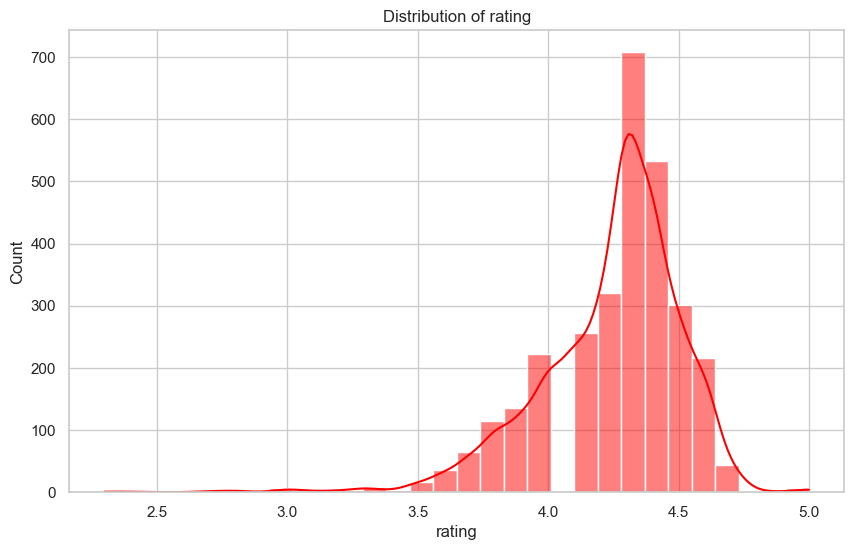

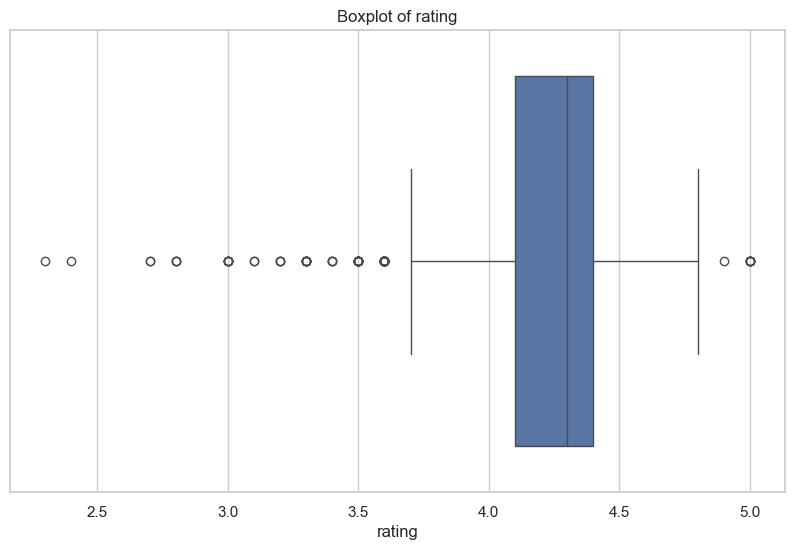

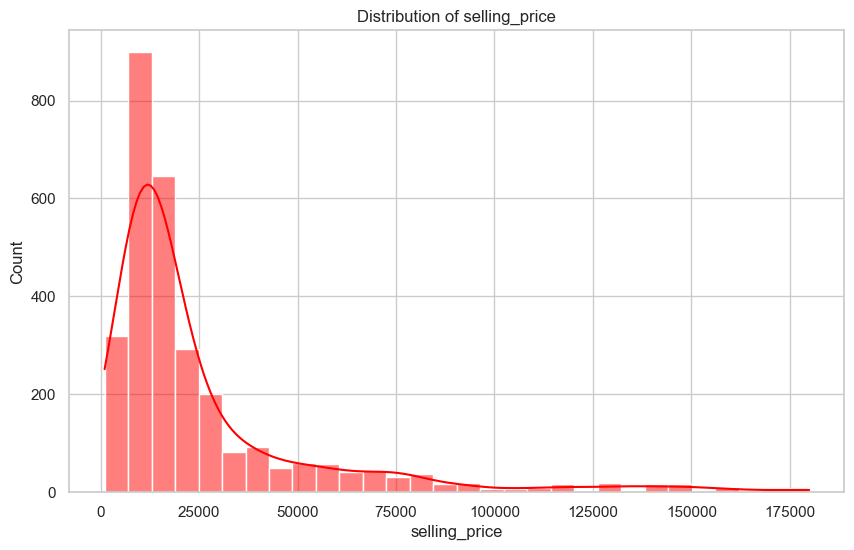

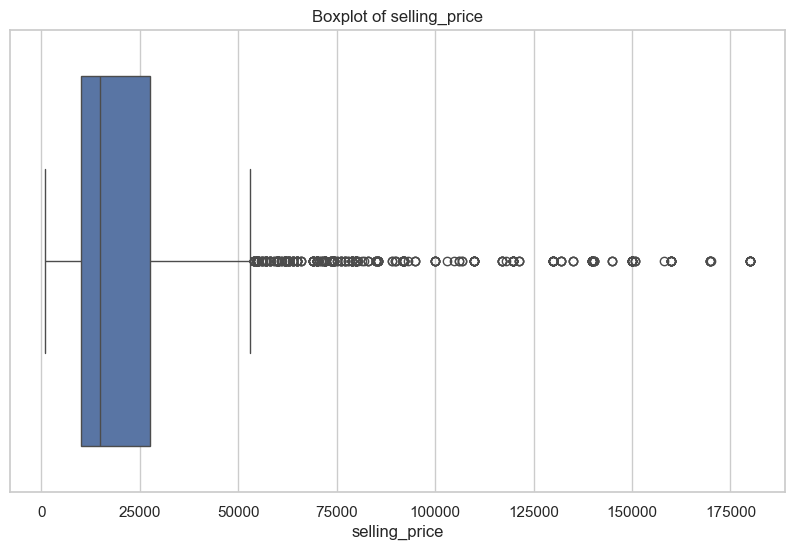

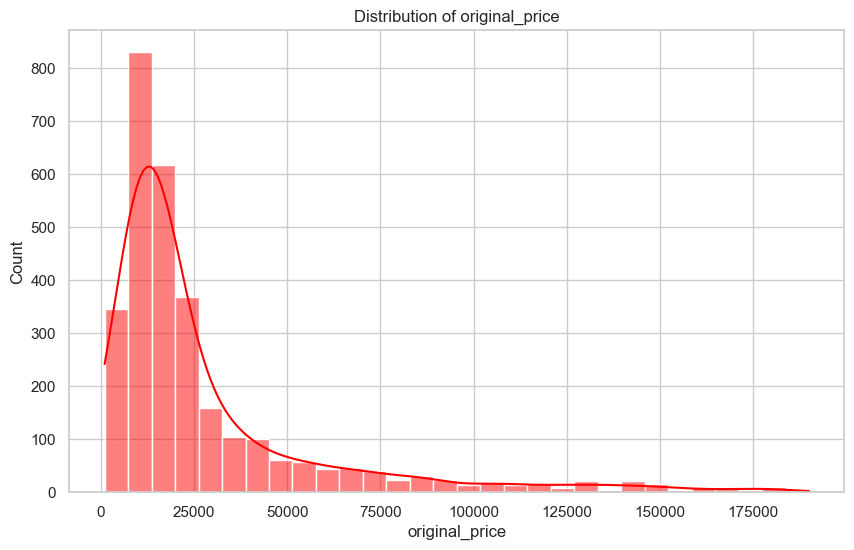

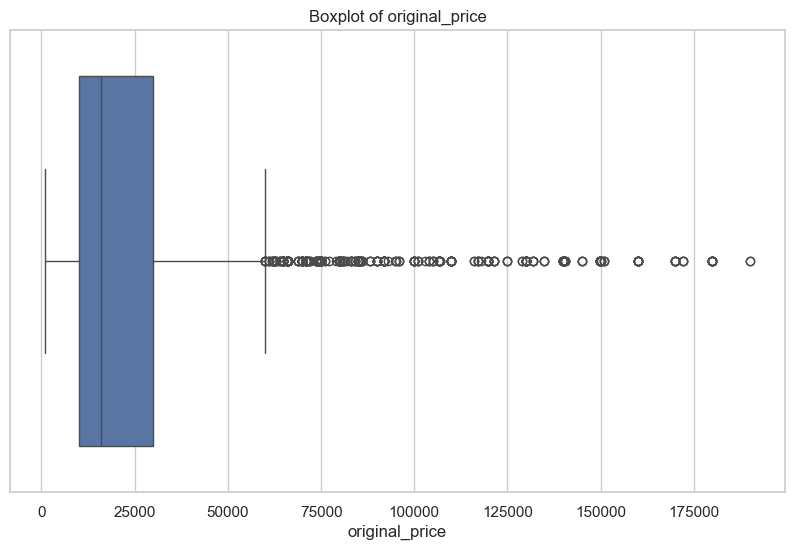

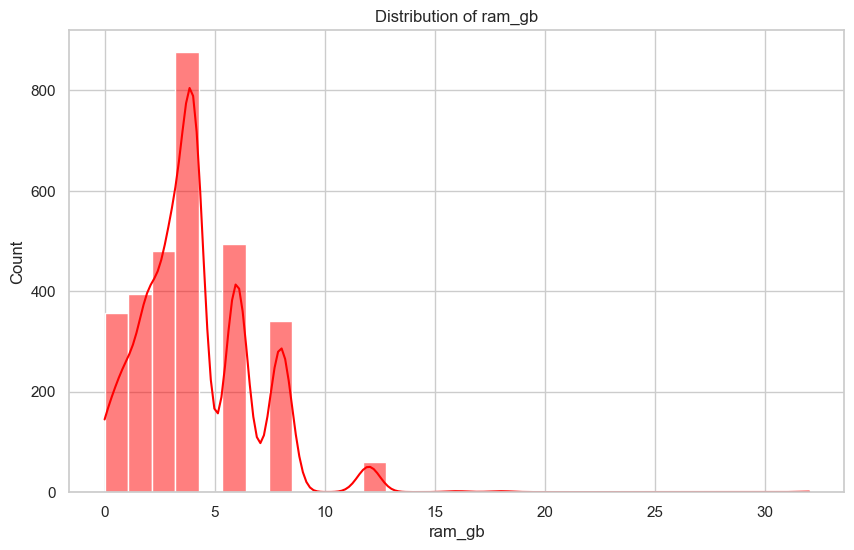

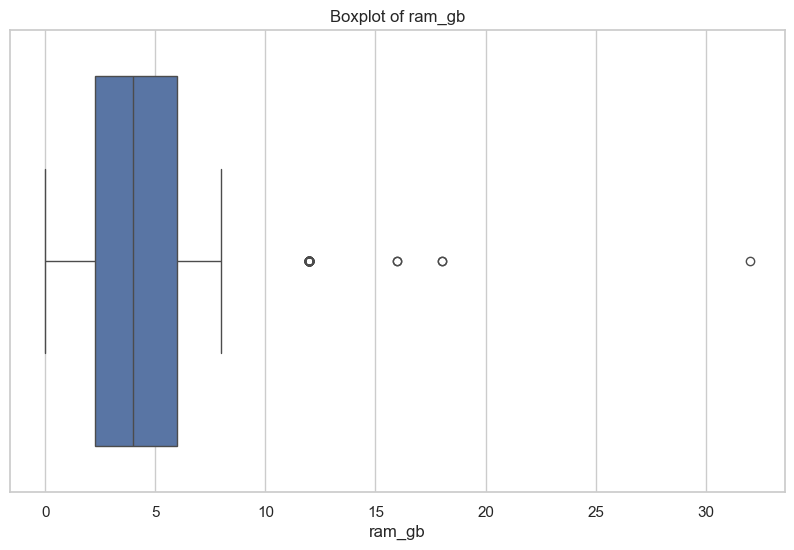

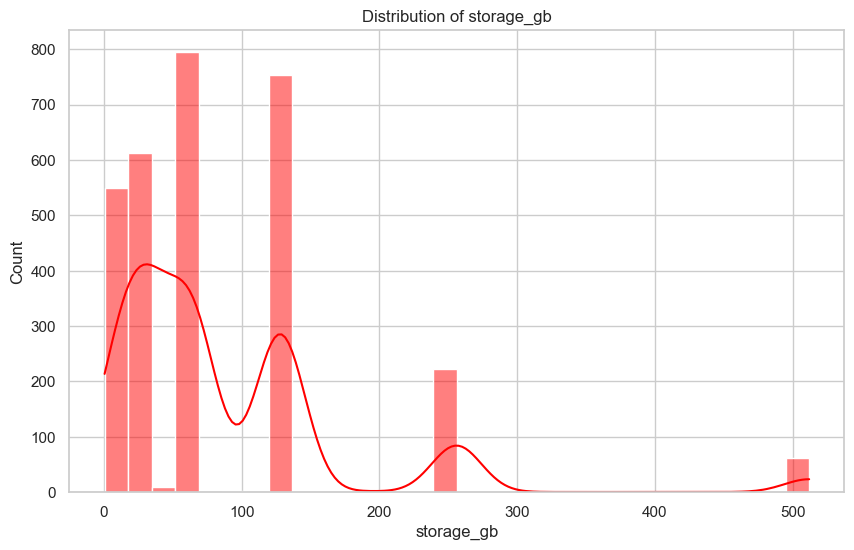

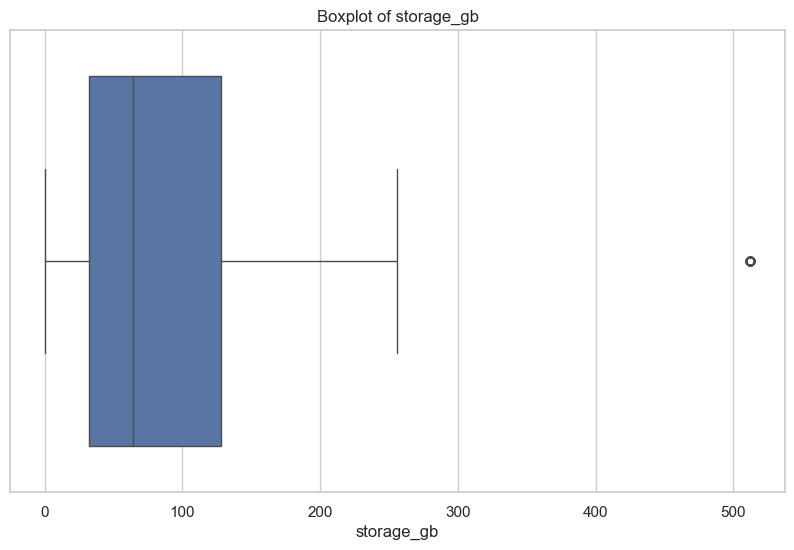

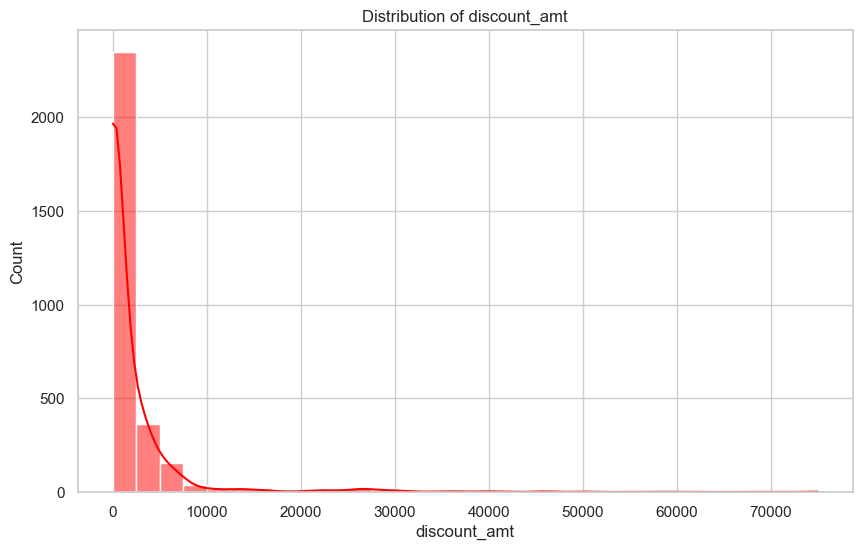

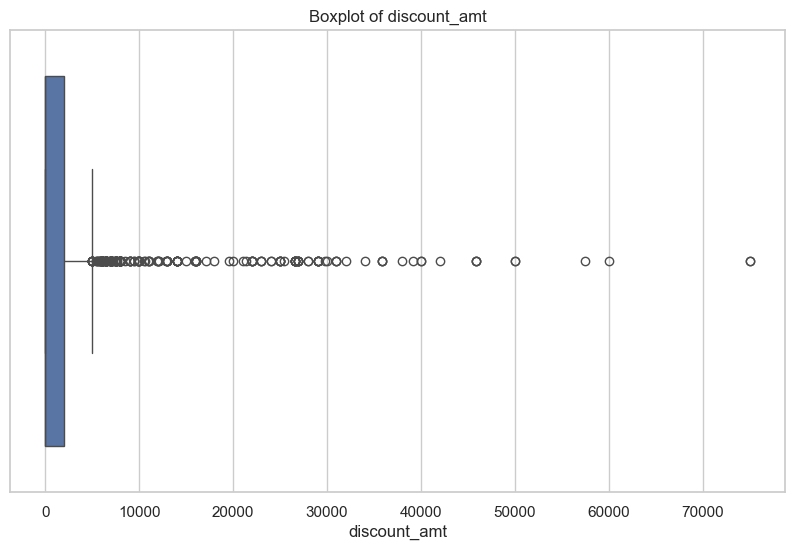

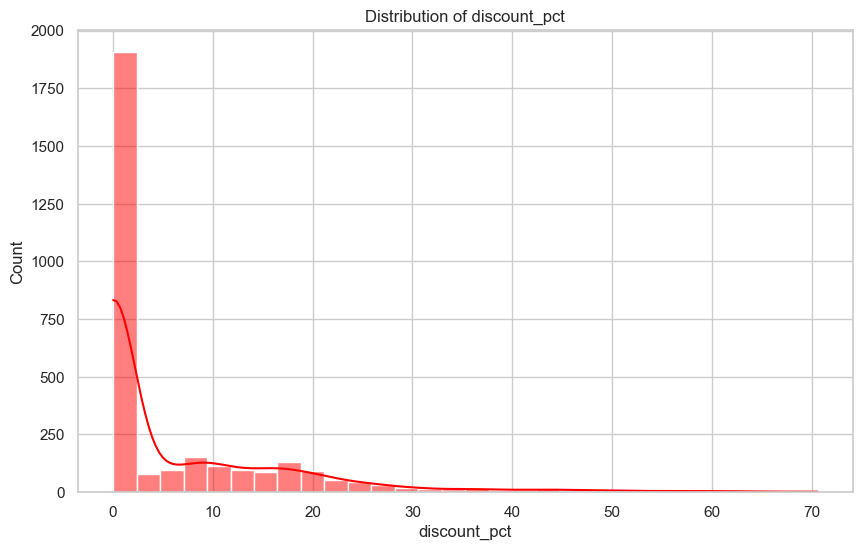

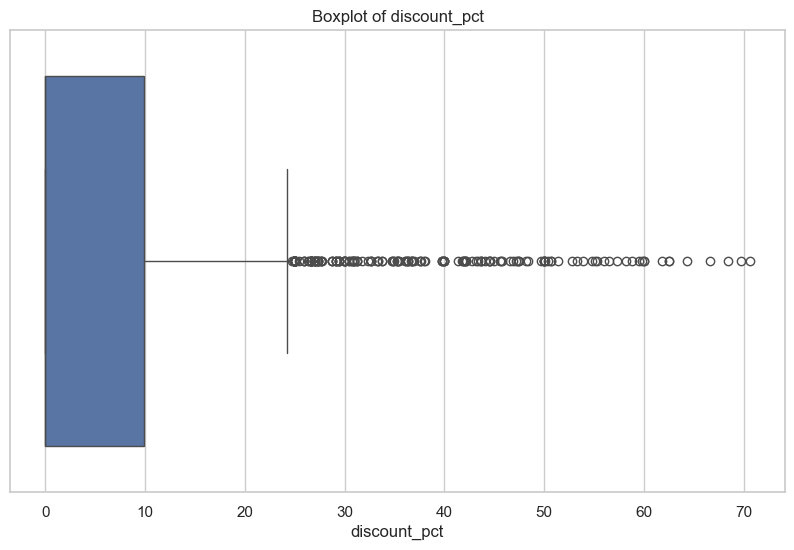

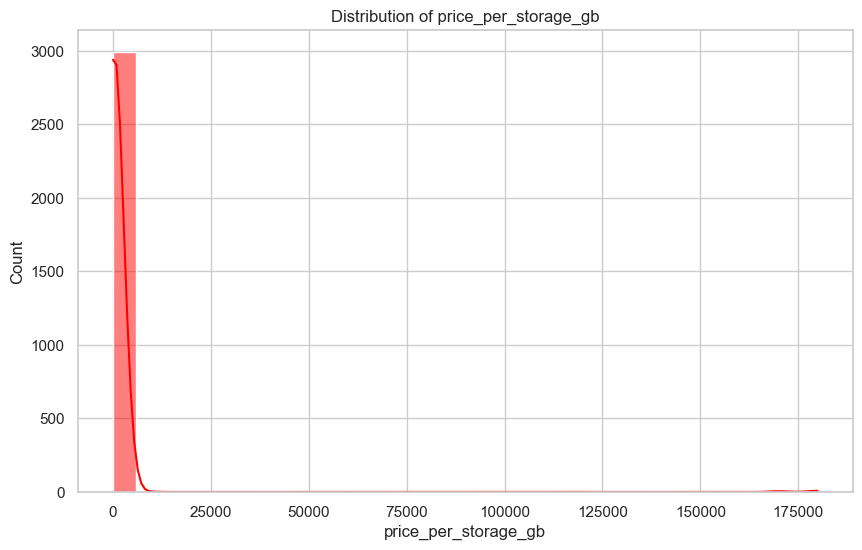

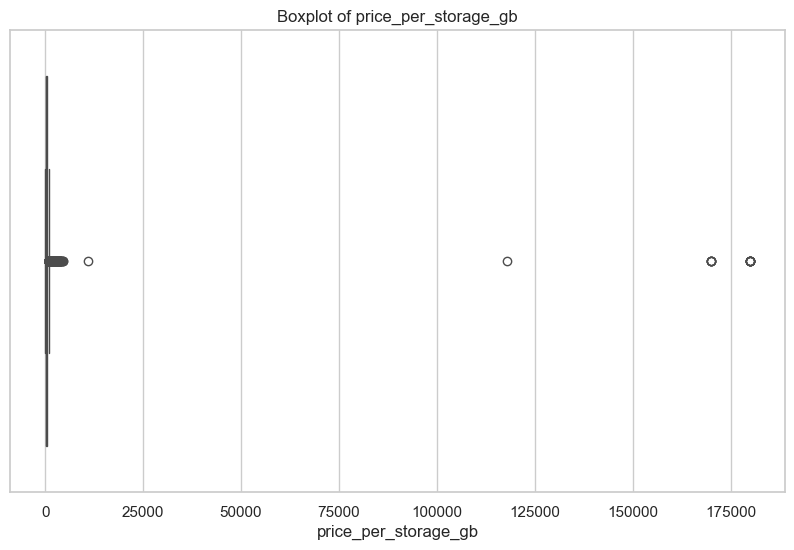

In [67]:
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=30,color='red')
    plt.title(f'Distribution of {col}')
    plt.show()
    
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


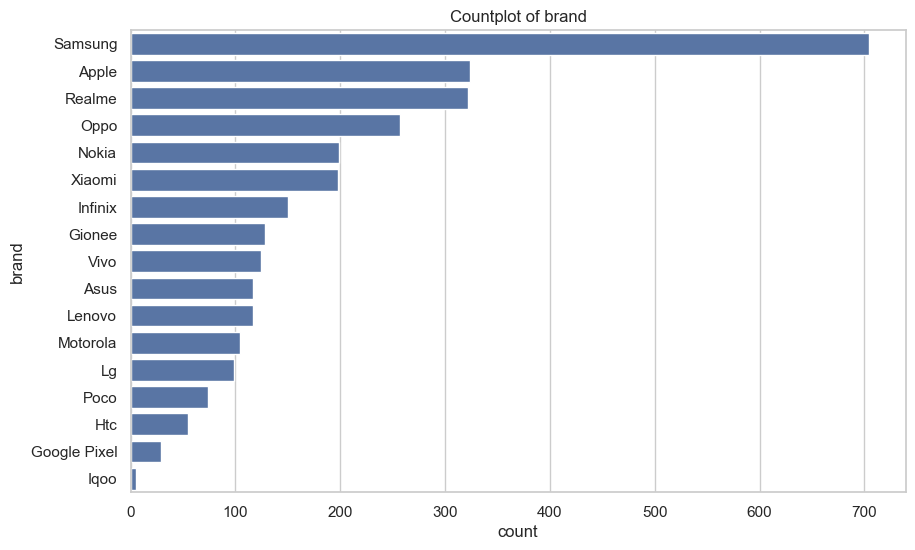

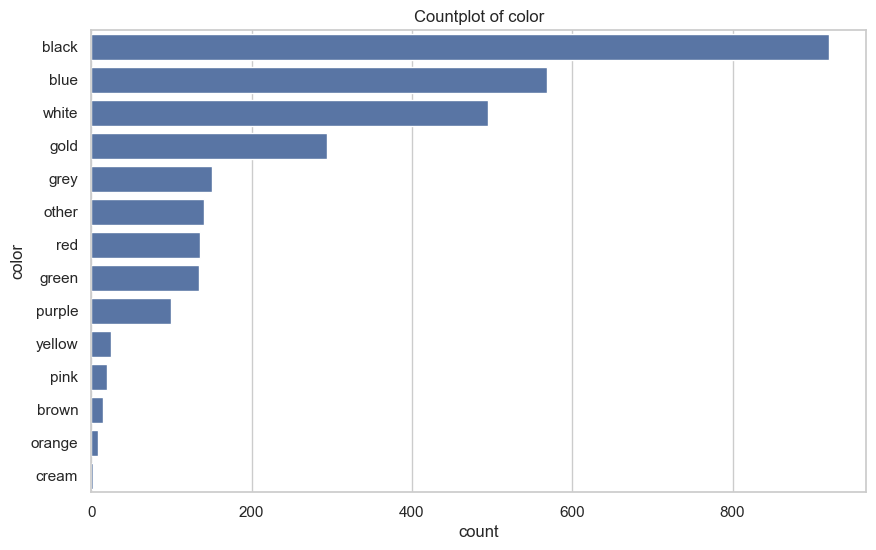

In [68]:
for col in ['brand','color']:
    plt.figure()
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Countplot of {col}')
    plt.show()


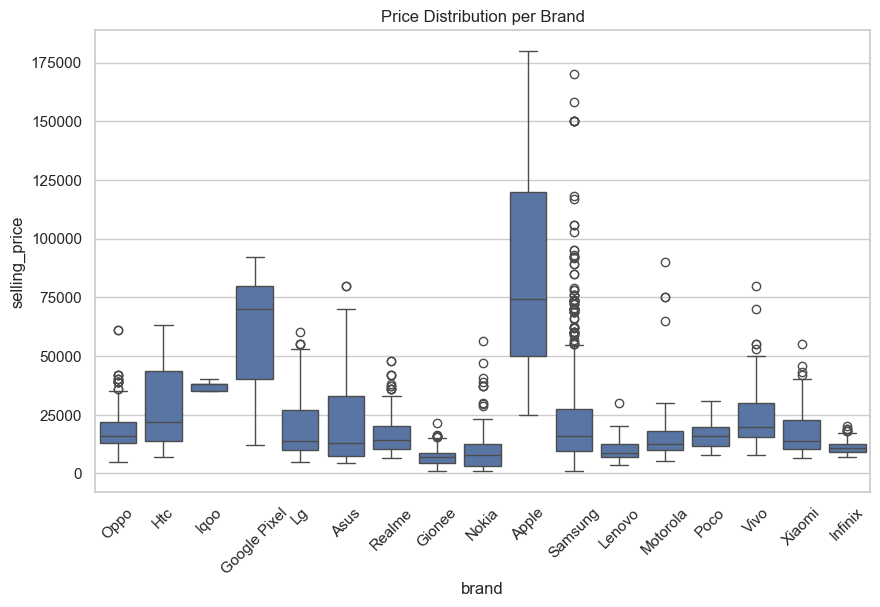

In [69]:
plt.figure()
sns.boxplot(x='brand', y='selling_price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution per Brand')
plt.show()


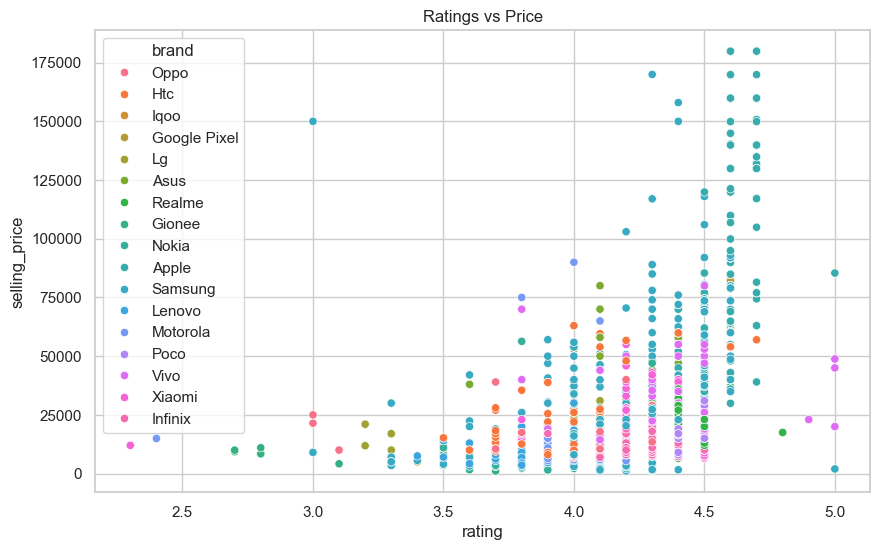

In [70]:
plt.figure()
sns.scatterplot(x='rating', y='selling_price', hue='brand', data=df)
plt.title('Ratings vs Price')
plt.show()


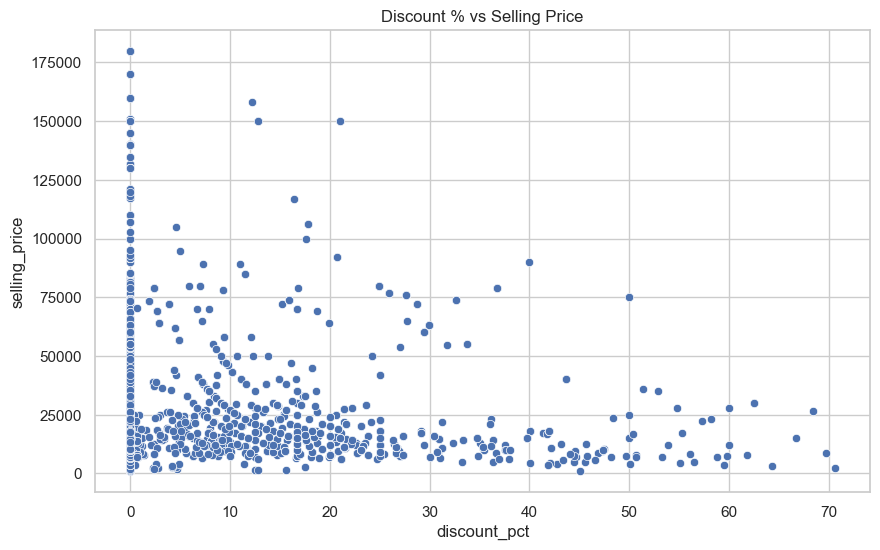

In [71]:
plt.figure()
sns.scatterplot(x='discount_pct', y='selling_price', data=df)
plt.title('Discount % vs Selling Price')
plt.show()


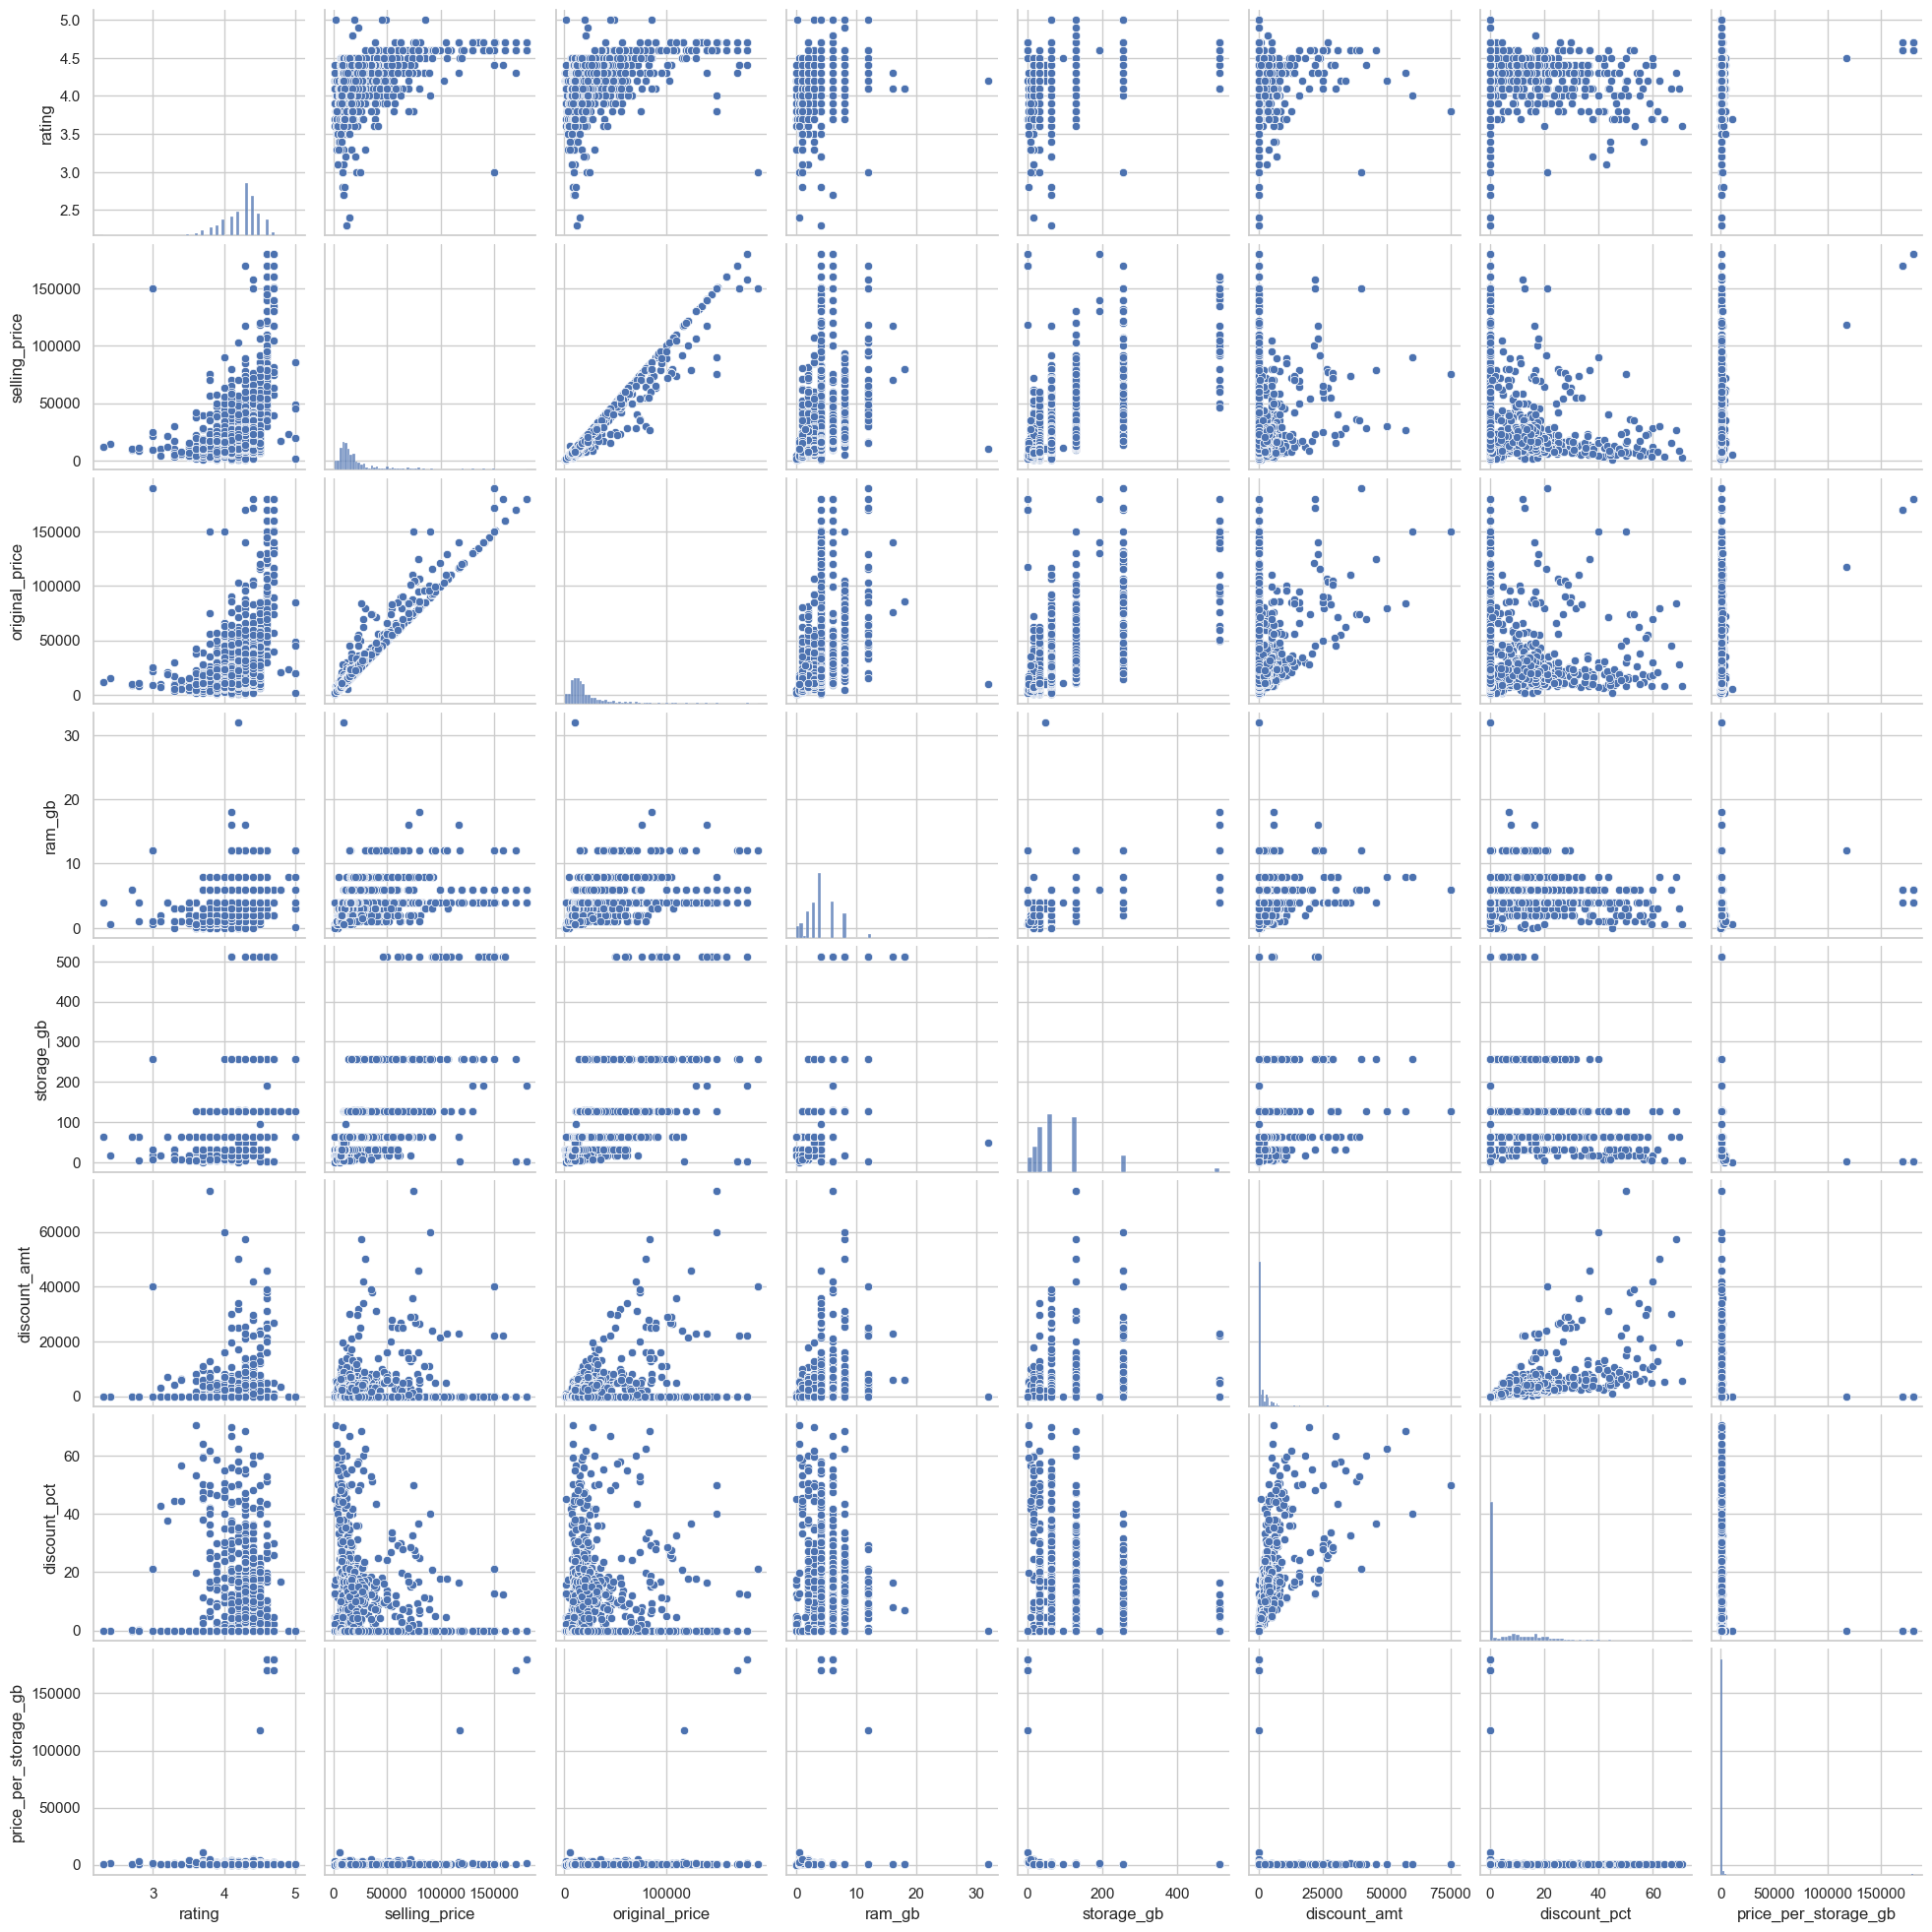

In [72]:
sns.pairplot(df[numeric_cols])
plt.show()


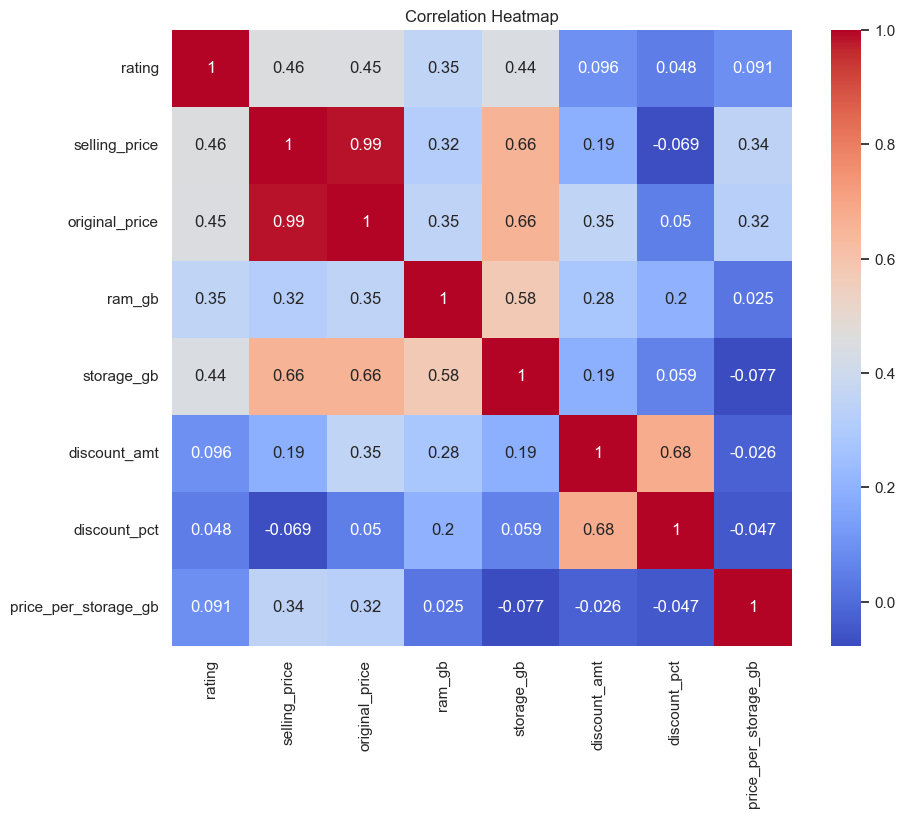

In [73]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [74]:
# Average price per brand
df.groupby('brand')['selling_price'].mean().sort_values(ascending=False)

# Average discount per storage
df.groupby('storage_gb')['discount_pct'].mean()


storage_gb
0.5      0.000000
1.0      0.000000
4.0      3.827500
8.0      1.875489
16.0     2.810988
32.0     4.489592
48.0     9.616667
64.0     7.306013
96.0     0.000000
128.0    9.214726
129.0    0.000000
130.0    0.000000
192.0    0.000000
256.0    6.996261
512.0    1.145410
Name: discount_pct, dtype: float64

In [75]:
for col in numeric_cols:
    print(f'{col}: skew={df[col].skew():.2f}, kurtosis={df[col].kurt():.2f}')


rating: skew=-1.31, kurtosis=4.03
selling_price: skew=2.66, kurtosis=7.68
original_price: skew=2.52, kurtosis=6.72
ram_gb: skew=1.28, kurtosis=6.20
storage_gb: skew=2.53, kurtosis=8.41
discount_amt: skew=6.27, kurtosis=52.86
discount_pct: skew=2.32, kurtosis=6.34
price_per_storage_gb: skew=14.67, kurtosis=214.62


In [76]:
#Does average price differ between Samsung and Apple

from scipy.stats import ttest_ind

samsung_price = df[df['brand']=='Samsung']['selling_price']
apple_price = df[df['brand']=='Apple']['selling_price']

t_stat, p_value = ttest_ind(samsung_price, apple_price)
print(f'T-statistic: {t_stat:.2f}, p-value: {p_value:.4f}')


T-statistic: -29.68, p-value: 0.0000


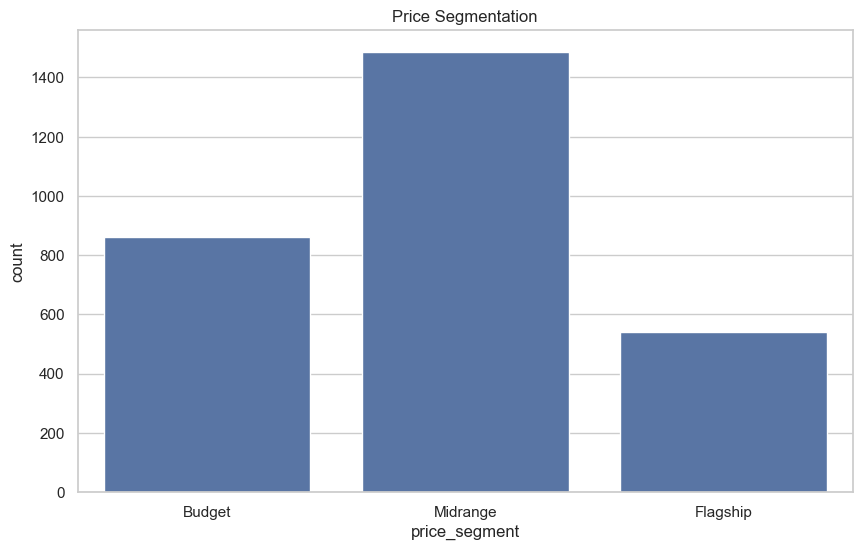

In [77]:
bins = [0, 10000, 30000, 100000]
labels = ['Budget','Midrange','Flagship']
df['price_segment'] = pd.cut(df['selling_price'], bins=bins, labels=labels)

sns.countplot(x='price_segment', data=df)
plt.title('Price Segmentation')
plt.show()


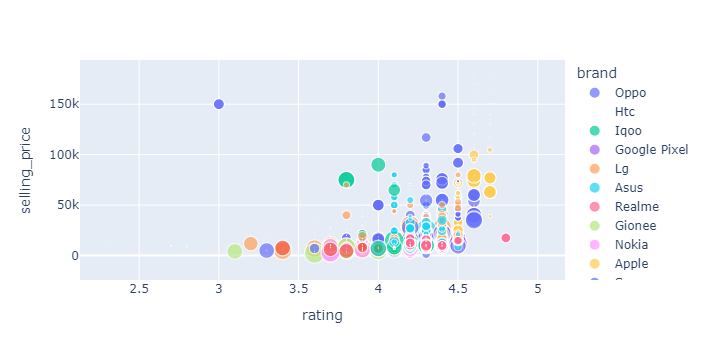

In [78]:
import plotly.express as px

# Scatter plot: Price vs Rating, color by brand, size by discount %
fig = px.scatter(df, 
                 x='rating', 
                 y='selling_price', 
                 color='brand', 
                 size='discount_pct',
                 hover_data=['model','ram_gb','storage_gb'])
fig.show()


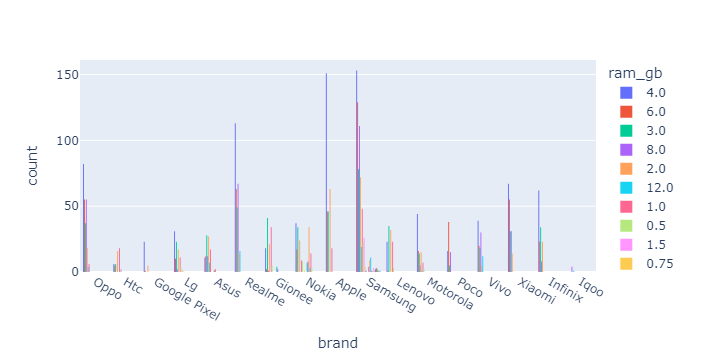

In [79]:
fig = px.histogram(df, 
                   x='brand', 
                   color='ram_gb', 
                   barmode='group', 
                   hover_data=['selling_price','storage_gb'])
fig.show()


In [81]:
# Determine max price dynamically
max_price = df['selling_price'].max()

bins = [0, 10000, 30000, max_price+1]  # extend upper limit
labels = ['Budget','Midrange','Flagship']

df['price_segment'] = pd.cut(df['selling_price'], bins=bins, labels=labels)


In [82]:
df_sunburst = df.dropna(subset=['price_segment'])

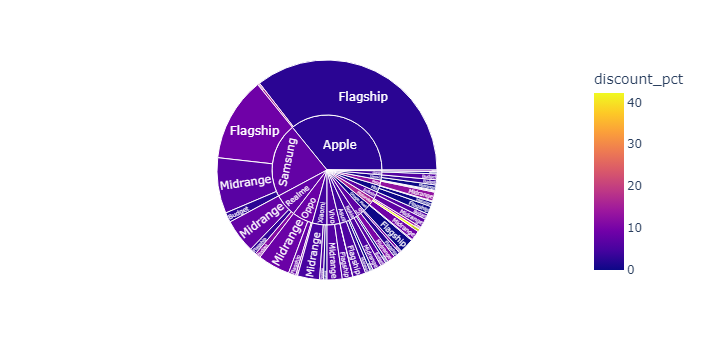

In [83]:
import plotly.express as px

fig = px.sunburst(df_sunburst, 
                  path=['brand','price_segment'], 
                  values='selling_price', 
                  color='discount_pct',
                  hover_data=['rating'])
fig.show()


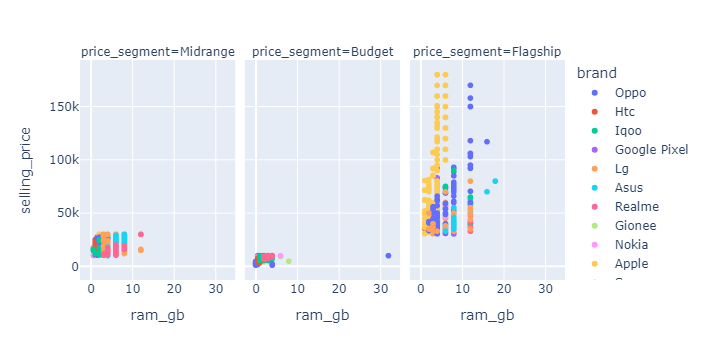

In [84]:
fig = px.scatter(df, x='ram_gb', y='selling_price', color='brand', facet_col='price_segment', hover_data=['model'])
fig.show()


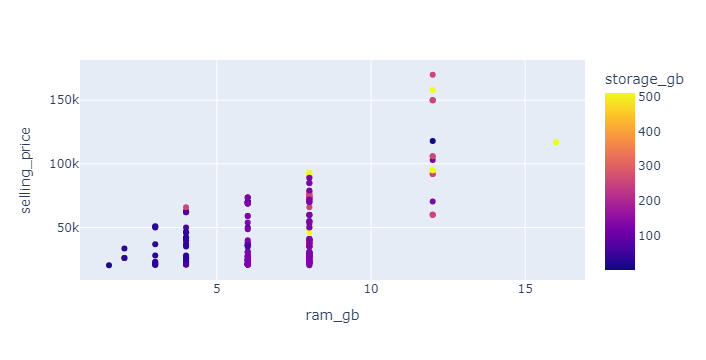

In [85]:
# Example: Filter Samsung mobiles with price > 20000 and rating > 4
filtered_df = df[(df['brand']=='Samsung') & (df['selling_price']>20000) & (df['rating']>4)]

fig = px.scatter(filtered_df, x='ram_gb', y='selling_price', color='storage_gb', hover_data=['model'])
fig.show()


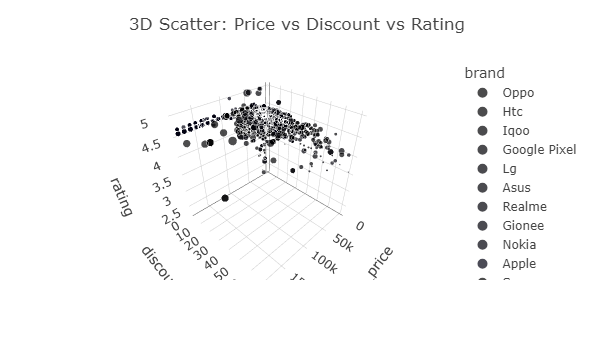

In [92]:
import plotly.express as px

fig = px.scatter_3d(df, x='selling_price', y='discount_pct', z='rating',
                    color='brand', size='ram_gb',
                    hover_data=['model','storage_gb'])
fig.update_layout(title='3D Scatter: Price vs Discount vs Rating')
fig.show()


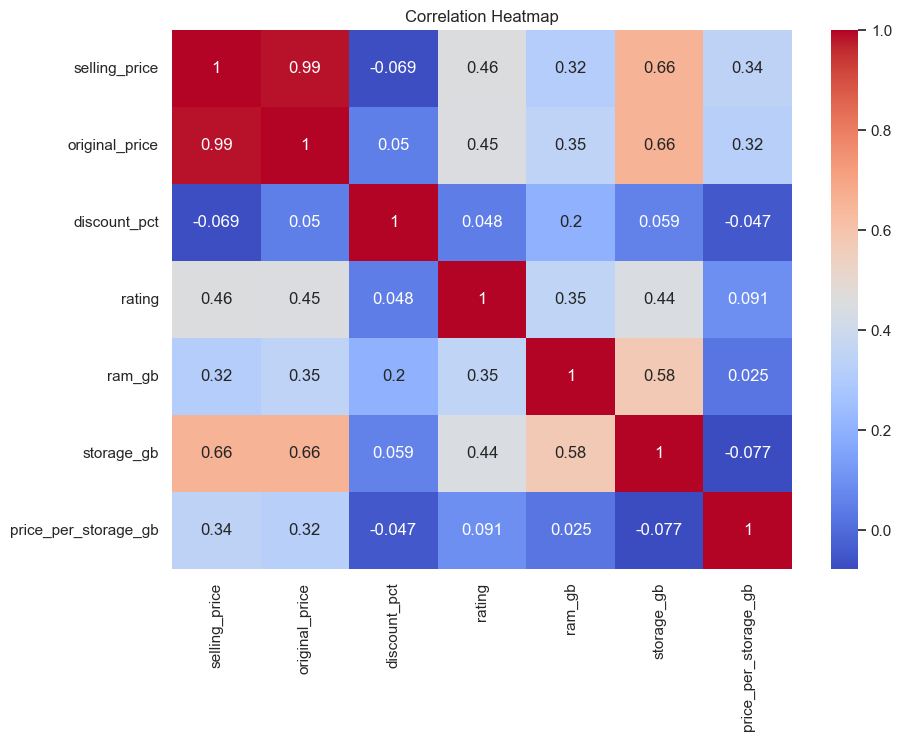

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
sns.heatmap(df[['selling_price','original_price','discount_pct','rating','ram_gb','storage_gb','price_per_storage_gb']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


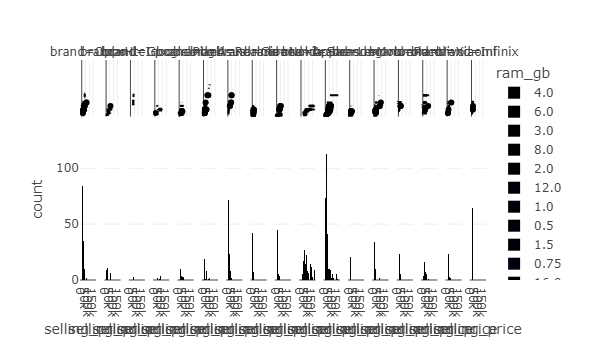

In [95]:
fig = px.histogram(df, x='selling_price', color='ram_gb', facet_col='brand', marginal='box')
fig.show()


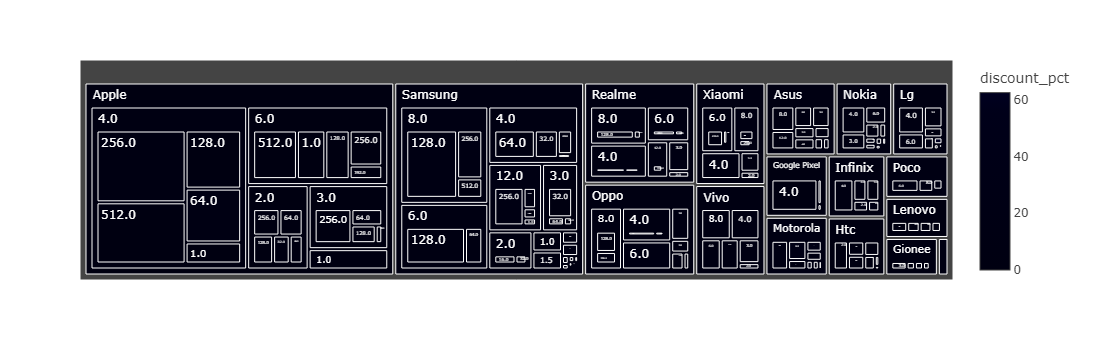

In [96]:
fig = px.treemap(df, path=['brand','ram_gb','storage_gb'], values='selling_price', color='discount_pct',
                 hover_data=['model','rating'])
fig.show()


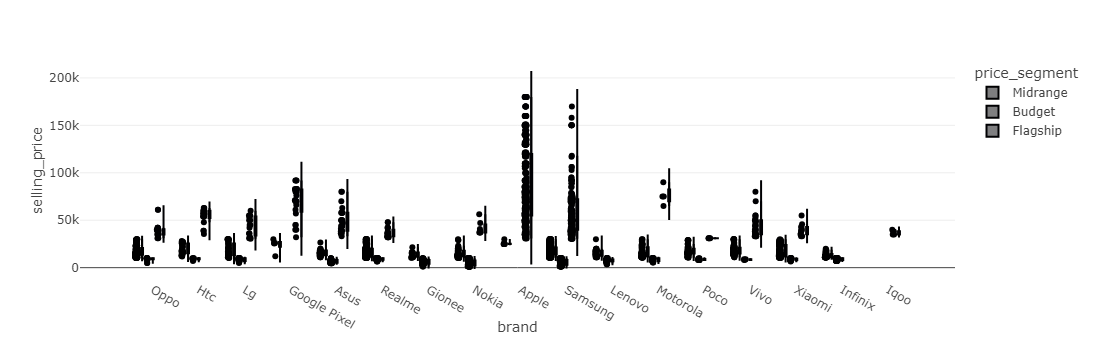

In [97]:
fig = px.violin(df, x='brand', y='selling_price', color='price_segment', box=True, points='all', hover_data=['model'])
fig.show()


In [98]:
Q1 = df['price_per_storage_gb'].quantile(0.25)
Q3 = df['price_per_storage_gb'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['price_per_storage_gb'] < Q1 - 1.5*IQR) | (df['price_per_storage_gb'] > Q3 + 1.5*IQR)]
print(outliers[['brand','model','price_per_storage_gb']])


             brand              model  price_per_storage_gb
194           Oppo            R1 R829               1340.75
198           Oppo            R1 R829               1561.88
215           Oppo                 F1                983.69
253   Google Pixel                  3               1093.73
255   Google Pixel                  3               1109.38
...            ...                ...                   ...
2942         Apple  iPhone 13 Pro Max               1014.84
2943         Apple  iPhone 13 Pro Max             179900.00
2944         Apple  iPhone 13 Pro Max               1014.84
2949         Apple  iPhone 13 Pro Max             179900.00
2950         Apple  iPhone 13 Pro Max             179900.00

[320 rows x 3 columns]
